In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Network(nn.Module):
    def __init__(self, input_size, output_size, activation = nn.Identity()):
        super(Network, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation
        
        self.fc1 = nn.Linear(self.input_size, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, self.output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.activation(x)

        return x


In [2]:
df = pd.read_csv('cleaned_dataset.csv')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = df[df['trading_day'] == 25]
data = data.drop(['trading_day'], axis=1)
data = data[['AskPrice1', 'AskVolume1', 'BidPrice1', 'BidVolume1', 'AskPrice2', 'AskVolume2', 'BidPrice2', 'BidVolume2', 'AskPrice3', 'AskVolume3', 'BidPrice3', 'BidVolume3']]
train_data = data.iloc[:20000, :]
test_data = data.iloc[20000:25000, :]
train_data

,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,BidVolume2,AskPrice3,AskVolume3,BidPrice3,BidVolume3
1887801,769.0,40,768.5,116,769.5,293,768.0,293,770.0,603,767.5,154
1887802,768.5,5,768.0,293,769.0,132,767.5,184,769.5,338,767.0,323
1887803,768.5,4,768.0,303,769.0,311,767.5,305,769.5,396,767.0,364
1887804,769.0,185,768.5,24,769.5,409,768.0,357,770.0,754,767.5,317
1887805,769.0,163,768.5,23,769.5,417,768.0,458,770.0,765,767.5,319
...,...,...,...,...,...,...,...,...,...,...,...,...
1907796,773.0,1077,772.5,291,773.5,1149,772.0,550,774.0,1272,771.5,542
1907797,773.0,1072,772.5,294,773.5,1149,772.0,558,774.0,1272,771.5,542
1907798,773.0,1073,772.5,295,773.5,1149,772.0,558,774.0,1272,771.5,542
1907799,773.0,1071,772.5,294,773.5,1149,772.0,559,774.0,1272,771.5,542


In [3]:
window_size = 40
def mid_price_change_label(dataset, window_size):
    dataset['mid_price_change'] = -(dataset[f'BidPrice1_lag_{window_size}'] + dataset[f'AskPrice1_lag_{window_size}']) / 2 + (dataset['BidPrice1_lag_1'] + dataset['AskPrice1_lag_1']) / 2
    dataset['mid_price_change_label'] = dataset['mid_price_change'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    dataset = dataset.drop(['mid_price_change'], axis=1)
    return dataset

def transform_dataframe(df, window_size):
    # Collect the columns
    columns = [f"{col}_lag_{i}" for i in range(window_size, 0, -1) for col in df.columns]
    transformed_data = []
    for i in range(len(df) - window_size):
        row_data = df.iloc[i:i+window_size].values.flatten()
        transformed_data.append(row_data)

    transformed_df = pd.DataFrame(transformed_data, columns=columns)
    
    return transformed_df


In [4]:
new_train_data = transform_dataframe(train_data, window_size)
new_train_data = mid_price_change_label(new_train_data, window_size)
new_train_data['mid_price_change_label'].value_counts()

 0    12941
 1     3622
-1     3397
Name: mid_price_change_label, dtype: int64

In [5]:
# import the random forest classifier
from sklearn.ensemble import RandomForestClassifier

X = new_train_data[new_train_data.columns[:-1]]
y = new_train_data[new_train_data.columns[-1]]

clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0, n_jobs=-1)
clf.fit(X, y)

# check the accuracy
clf.score(X, y)

0.7847194388777555

In [6]:
new_test_data = transform_dataframe(test_data, window_size)
probabilities_test = clf.predict_proba(new_test_data)
probabilities_test
# drop the last 40 rows of the test data
test_data = test_data[:-40]
# add the probabilities to the dataframe
test_data['probabilities_down'] = probabilities_test[:,0]
test_data['probabilities_unchange'] = probabilities_test[:,1]
test_data['probabilities_up'] = probabilities_test[:,2]
test_data = torch.tensor(test_data.values)
test_data.to(device)

tensor([[7.7300e+02, 1.0890e+03, 7.7250e+02,  ..., 5.4776e-02, 5.6869e-01,
         3.7653e-01],
        [7.7300e+02, 1.0890e+03, 7.7250e+02,  ..., 5.6360e-02, 5.6768e-01,
         3.7596e-01],
        [7.7300e+02, 1.0900e+03, 7.7250e+02,  ..., 5.6401e-02, 5.6415e-01,
         3.7945e-01],
        ...,
        [7.7200e+02, 2.4700e+02, 7.7150e+02,  ..., 1.6970e-01, 7.7297e-01,
         5.7327e-02],
        [7.7200e+02, 2.8500e+02, 7.7150e+02,  ..., 1.6970e-01, 7.7297e-01,
         5.7327e-02],
        [7.7200e+02, 3.1000e+02, 7.7150e+02,  ..., 1.6825e-01, 7.7465e-01,
         5.7100e-02]], device='cuda:0', dtype=torch.float64)

In [7]:
# write a function to get a path from the policy network
def get_path(policy_network, train_dataset):
    holding_positions = [0]
    pos_changes = []
    rewards = []
    states1 = []
    states2 = [] 
    action_dist_set = []
    action_set = []
    for i in range(len(train_dataset)):

        # bid_ask information of past 10 snapshots
        bid_ask = train_dataset[i, :]
        old_hold = holding_positions[-1]
        hold = torch.tensor([old_hold]).float().to(device)
        states1.append(bid_ask)
        states2.append(hold)
        x = torch.cat((bid_ask, hold)).float().to(device)
        # get the action from the policy network, which is a probability distribution
        action_dist = policy_network(x)
        action_dist_set.append(action_dist)
        # sample an action from the probability distribution
        action = torch.multinomial(action_dist, 1).item() - 1
        action_set.append(action + 1)
        
        # decide the position change based on the action and current holding position
        if old_hold == 0:
            # make the action to be integer
            a = int(action)
            holding_positions.append(a)
        if old_hold == 1:
            holding_positions.append(min(action + old_hold, old_hold))
        if old_hold == -1:
            holding_positions.append(max(action + old_hold, old_hold))
           
        # compute the reward (cash change) 
        new_hold = holding_positions[-1]
        position_change = new_hold - old_hold
        pos_changes.append(position_change)
    
        reward = 0
        if position_change == 0:
            reward = 0
        if position_change == 1:
            reward = - train_dataset[i][2] 
        if position_change == -1:
            reward = train_dataset[i][0] 

        rewards.append(reward)
    
    # at the end, the agent needs to liquid all positions
    if holding_positions[-1] == 1:
        rewards.append(train_dataset[-1][2])
    elif holding_positions[-1] == -1:
        rewards.append(-train_dataset[-1][0])
    else:
        rewards.append(0)

    # convert the list of rewards to a tensor
    rewards = torch.tensor(rewards).float().to(device)
    # convert the list of states to a tensor
    states1 = torch.stack(states1).to(device)
    states2 = torch.stack(states2).to(device)
    action_dist_set = torch.stack(action_dist_set).to(device)
    return states1, states2, rewards, action_dist_set, action_set


        
# train the value network using the TD(0) algorithm
def train_value_network(value_network, policy_network, train_dataset, value_optimizer, gamma = 0.99, epochs = 20):
    # define the loss function
    loss = 0
    losses = []
    # loop over the epochs
    for epoch in range(epochs):
        # get the path from the policy network
        # only use one trajectory each epoch
        states1, states2, rewards, action_dist_set, action_set = get_path(policy_network, train_dataset)
        # get the value estimate from the value network
        a = torch.cat((states1, states2), dim = 1).float().to(device)
        # get the value estimate from the value network
        # wish to compute the outputs of batch paralellly
        value_estimate = value_network(a)
        value_estimate = value_estimate.squeeze(1)
        new_value_estimate = torch.cat((value_estimate, torch.tensor([0]).to(device)))
        # compute the TD(0) error
        loss = (rewards[:-1] + gamma * new_value_estimate[1:] - new_value_estimate[:-1]).pow(2).mean()
        # zero the gradient
        value_optimizer.zero_grad()
        # compute the gradient
        loss.backward()
        # update the weights
        value_optimizer.step()
        # print the loss
        losses.append(loss.item())
        if (epoch - 4) % 5 == 0:
            print('value epoch: {}, value loss: {:.5f}'.format(epoch + 1, loss.item()))

    #plt.figure(figsize = (10, 5))
    #plt.plot(losses)
    #plt.xlabel('Epoch')
    #plt.ylabel('Loss')
    #plt.title('Loss over Epochs')
    #plt.show()
    return losses


# the following define a function that compute advantage estimation for a trajectory
def advantage_estimate(states1, states2, rewards, value_network, gamma):
    a = torch.cat((states1, states2), dim = 1).float().to(device)
    value_estimate = value_network(a)
    value_estimate = value_estimate.squeeze(1)
    new_value_estimate = torch.cat((value_estimate, torch.tensor([0]).to(device)))
    advantages = rewards[:-1] + gamma * new_value_estimate[1:] - new_value_estimate[:-1]
    return advantages

In [8]:
test_data = test_data.to(device)
policy_network = Network(16, 3, nn.Softmax())
value_network = Network(16, 1)
policy_network = nn.DataParallel(policy_network)
value_network = nn.DataParallel(value_network)
policy_network.to(device)
value_network.to(device)

policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.05)
value_optimizer = optim.Adam(value_network.parameters(), lr=0.05)

In [9]:
# states, rewards, actions are trajetory data of old policy
# there is a new_policy_network that is updated by ppo_update()
def ppo_loss(new_policy_network, policy_network, value_network, train_dataset, batch_size, epsilon=0.2, gamma = 0.99):
    # batch size: the number of trajectories
    loss = torch.tensor(0.0, requires_grad=True).to(device)
    for _ in range(batch_size):
        states1, states2, rewards, action_dist_set, action_set = get_path(policy_network, train_dataset)
        a = torch.cat((states1, states2), dim = 1).float().to(device)
        new_action_dist_set = new_policy_network(a)
        action_dist_set = action_dist_set.detach()
        rewards = rewards.detach()
        ratio = []
        for i in range(len(action_dist_set)):
            ratio.append(new_action_dist_set[i][action_set[i]] / action_dist_set[i][action_set[i]])
        ratio = torch.stack(ratio).to(device).detach()
        # compute the advantage of the trajectory
        advantage = advantage_estimate(states1, states2, rewards, value_network, gamma)
        advantage = advantage.detach()
        # compute the clipped ratio
        clipped_ratio = torch.clamp(ratio, 1.0 - epsilon, 1.0 + epsilon)
        # compute the surrogate loss
        policy_loss = -torch.min(ratio * advantage, clipped_ratio * advantage).mean()
        # compute the total loss
        loss = loss + policy_loss
    return loss

    
def ppo_train(new_policy_network, policy_network, value_network, optimizer, train_dataset, batch_size, epochs, epsilon=0.1, gamma = 0.99):
    
    for epoch in range(epochs):
        loss = ppo_loss(new_policy_network, policy_network, value_network, train_dataset, batch_size, epsilon, gamma)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return None
    


def wealth_dist(num_traj, policy_network, dataset):
    wealths = []
    for num in range(num_traj):
        states1, states2, rewards, action_dist_set, action_set = get_path(policy_network, dataset)
        wealths.append(sum(rewards))

    return wealths


In [10]:
num_iter = 20
# num_iter this is the number of times that we improve the policy
# batch_size is the number of trajectories used of computing ppo loss
# epoch is the number of trains for ppo updates
#torch._dynamo.config.suppress_errors = True
wealth_records = []
value_losses = []
ppo = []

oldest_policy_network = Network(16, 3, activation = nn.Softmax()).to(device)
oldest_policy_network.load_state_dict(policy_network.state_dict(), strict=False)

for iteration in range(num_iter):
    print("iteration: ", iteration)
    value_loss = train_value_network(value_network, policy_network, test_data, value_optimizer, 0.9, epochs = 1)
    value_losses += value_loss
    new_policy_network = Network(16, 3, activation = nn.Softmax()).to(device)
    new_policy_network.load_state_dict(policy_network.state_dict(), strict=False)
    new_policy_network = nn.DataParallel(new_policy_network)
    new_policy_optimizer = optim.Adam(new_policy_network.parameters(), lr = 0.05)
        
    ppo_train(new_policy_network, policy_network, value_network, new_policy_optimizer, test_data, batch_size = 1, epochs = 1, epsilon = 0.1, gamma = 0.99)
    policy_network = new_policy_network

    print('this is value loss')
    print(value_losses[-1])
    loss = ppo_loss(policy_network, oldest_policy_network, value_network, test_data, 1, epsilon=0.2, gamma = 0.99)
    ppo.append(loss.item())
    print('this is ppo loss')
    print(ppo[-1])

iteration:  0


C:\Users\specf\AppData\Local\Temp\ipykernel_18932\2461009522.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activation(x)


this is value loss
19956.365234375
this is ppo loss
1110.7021484375
iteration:  1
this is value loss
169943808.0
this is ppo loss
-30.931289672851562
iteration:  2
this is value loss
45530192.0
this is ppo loss
753.4652099609375
iteration:  3
this is value loss
52666400.0
this is ppo loss
-34.64098358154297
iteration:  4
this is value loss
19515034.0
this is ppo loss
-64.69666290283203
iteration:  5
this is value loss
13157037.0
this is ppo loss
25.505508422851562
iteration:  6
this is value loss
3820029.0
this is ppo loss
14.891536712646484
iteration:  7
this is value loss
295471.0
this is ppo loss
70.13506317138672
iteration:  8
this is value loss
581191.6875
this is ppo loss
-23.04377555847168
iteration:  9
this is value loss
2398718.0
this is ppo loss
137.6840362548828
iteration:  10
this is value loss
1385142.5
this is ppo loss
6.238276958465576
iteration:  11
this is value loss
260371.453125
this is ppo loss
47.29439926147461
iteration:  12
this is value loss
968327.0
this is ppo

In [11]:
for iteration in range(num_iter):
    print("iteration: ", iteration)
    value_loss = train_value_network(value_network, policy_network, test_data, value_optimizer, 0.9, epochs = 1)
    value_losses += value_loss
    new_policy_network = Network(16, 3, activation = nn.Softmax()).to(device)
    new_policy_network.load_state_dict(policy_network.state_dict(), strict=False)
    new_policy_network = nn.DataParallel(new_policy_network)
    new_policy_optimizer = optim.Adam(new_policy_network.parameters(), lr = 0.05)
        
    ppo_train(new_policy_network, policy_network, value_network, new_policy_optimizer, test_data, batch_size = 1, epochs = 1, epsilon = 0.1, gamma = 0.99)
    policy_network = new_policy_network

    print('this is value loss')
    print(value_losses[-1])
    loss = ppo_loss(policy_network, oldest_policy_network, value_network, test_data, 5, epsilon=0.2, gamma = 0.99)
    ppo.append(loss.item())
    print('this is ppo loss')
    print(ppo[-1])

iteration:  0


C:\Users\specf\AppData\Local\Temp\ipykernel_18932\2461009522.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activation(x)


this is value loss
229116.6875
this is ppo loss
321.5639953613281
iteration:  1
this is value loss
387701.875
this is ppo loss
109.14295959472656
iteration:  2
this is value loss
370442.71875
this is ppo loss
-112.79515838623047
iteration:  3
this is value loss
119624.1796875
this is ppo loss
312.8014831542969
iteration:  4
this is value loss
417509.5
this is ppo loss
19.190290451049805
iteration:  5
this is value loss
35000.94921875
this is ppo loss
50.78168869018555
iteration:  6
this is value loss
379036.9375
this is ppo loss
212.34628295898438
iteration:  7
this is value loss
94844.375
this is ppo loss
220.34629821777344
iteration:  8
this is value loss
214866.171875
this is ppo loss
77.29939270019531
iteration:  9
this is value loss
91353.390625
this is ppo loss
-34.504638671875
iteration:  10
this is value loss
130813.96875
this is ppo loss
163.8693389892578
iteration:  11
this is value loss
79074.5859375
this is ppo loss
196.53526306152344
iteration:  12
this is value loss
10401

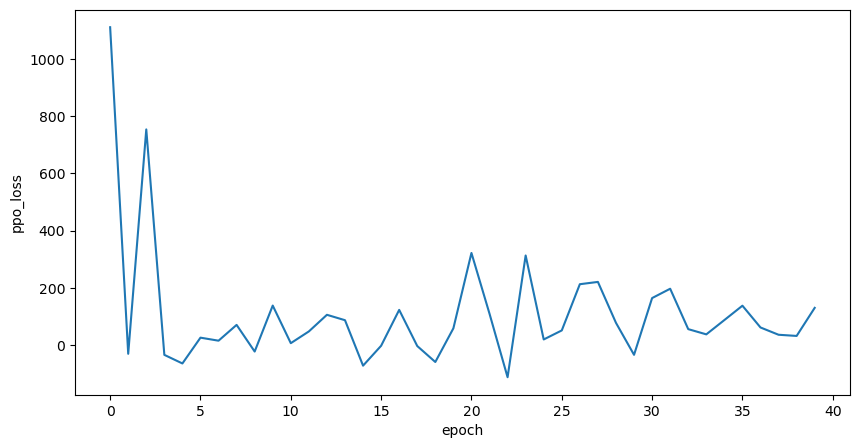

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(ppo)), ppo)
plt.ylabel('ppo_loss')
plt.xlabel('epoch')
plt.show()

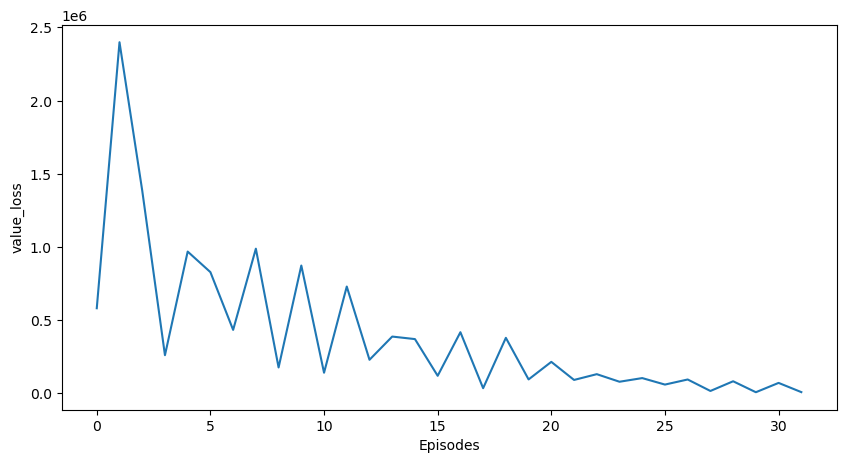

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(value_losses[8:])), value_losses[8:])
plt.ylabel('value_loss')
plt.xlabel('Episodes')
plt.show()